# header

In [ ]:
'''
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

setInterval(ConnectButton,60000);
'''

from google.colab import drive
from os import chdir

drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/Gproject/MIT_glyco'
chdir(project_path)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import os
from os.path import exists
print(os.getcwd()) # current working directory

update = False

/content/drive/MyDrive/Gproject/MIT_glyco


In [ ]:
load_name = "./data/data_for_ml.csv"
dataset = pd.read_csv(load_name)
protein_list = list(dataset.protein.unique())

positive = dataset[dataset['positivity']==1]
negative = dataset[dataset['positivity']==0]

print("total number of proteins:      ", len(dataset.protein.unique()))
print("total number of samples:       ", len(dataset))
print("total number of positive sites:", len(positive))
print("total number of negative sites:", len(negative))

total number of proteins:       272
total number of samples:        257578
total number of positive sites: 529
total number of negative sites: 257049


## parameter settings

In [ ]:
from src.Data import *
from src.Preprocessing import *
from src.models import *

variables = xy_variables()
test_size = 0.2
valid_size = test_size/(1-test_size)

import random
random_state = 1
n_cv = 10

hpo_counts = 30
hpo_config = {
    "n_layers" : range(1,11),
    "n_neurons" : [16, 32, 64, 128, 256]
}
metrics = ['rnn_layers', 'rnn_neurons', 'dnn_layers', 'dnn_neurons', 
           'epoch', 'time', 'loss', 'val_loss', 'test_loss', 'accuracy', 'precision', 'recall', 'f1']
method = "random"

# model

In [ ]:
model_name = 'rnn_basic'

x_cts   = variables.x_cts_original
x_cat   = variables.x_cat_original
y_label = variables.y_label

print(f"{len(x_cts)} x_cts: {x_cts}")
print(f"{len(x_cat)} x_cat: {x_cat}")
print(f"{len(y_label)} y_label: {y_label}")

data_x, data_y = df_to_dummy(dataset, x_cts, x_cat, y_label)
display(dict(zip(range(len(data_x.columns)), data_x.columns)))

11 x_cts: ['ASA', 'Phi', 'Psi', 'Theta(i-1=>i+1)', 'Tau(i-2=>i+2)', 'HSE_alpha_up', 'HSE_alpha_down', 'P(C)', 'P(H)', 'P(E)', 'flexibility']
2 x_cat: ['SEQ', 'SS']
1 y_label: ['positivity']
dummy x shape: (257578, 34)
dummy y shape: (257578, 1)


{0: 'ASA',
 1: 'Phi',
 2: 'Psi',
 3: 'Theta(i-1=>i+1)',
 4: 'Tau(i-2=>i+2)',
 5: 'HSE_alpha_up',
 6: 'HSE_alpha_down',
 7: 'P(C)',
 8: 'P(H)',
 9: 'P(E)',
 10: 'flexibility',
 11: 'SEQ_A',
 12: 'SEQ_C',
 13: 'SEQ_D',
 14: 'SEQ_E',
 15: 'SEQ_F',
 16: 'SEQ_G',
 17: 'SEQ_H',
 18: 'SEQ_I',
 19: 'SEQ_K',
 20: 'SEQ_L',
 21: 'SEQ_M',
 22: 'SEQ_N',
 23: 'SEQ_P',
 24: 'SEQ_Q',
 25: 'SEQ_R',
 26: 'SEQ_S',
 27: 'SEQ_T',
 28: 'SEQ_V',
 29: 'SEQ_W',
 30: 'SEQ_Y',
 31: 'SS_C',
 32: 'SS_E',
 33: 'SS_H'}

In [ ]:
window_size = 10

rnn_input  = []
rnn_output = []

for name in protein_list:
    load_path = f'./data/data_for_ml/{name}.csv'
    temp = pd.read_csv(load_path)
    temp_x, temp_y = custom_dummy(temp, x_cts, x_cat, y_label)
    
    temp_input, temp_output = data_to_sequence(temp_x, temp_y, window_size)
    rnn_input.append(temp_input)
    rnn_output.append(temp_output)
    
rnn_input  = np.concatenate(rnn_input, axis=0)
rnn_output = np.concatenate(rnn_output, axis=0)

## cross validation

In [ ]:
# select n_layers and n_neurons as the best values of HPO
rnn_layers = 2
rnn_neurons = 100
dnn_layers = 5
dnn_neurons = 100
cv_path = f'./result/cv_result_{model_name}_{rnn_layers}_{rnn_neurons}_{dnn_layers}_{dnn_neurons}_{n_cv}.csv'

cv_result = pd.DataFrame([], columns=metrics)
if not exists(cv_path) or update:
    for i in range(n_cv):
        print(f"\n{i+1}th iteration")
        random.seed(i+1)
        train_x, train_y, test_x, test_y, _, _ = stratified_split(rnn_input, rnn_output, 
                                                              test_size=test_size, random_state=i+1, 
                                                              scale_x=x_cts, scale_y=[])
        train_x, train_y = up_sampling(train_x, train_y)

        history_size = train_x.shape[1]
        x_dim = train_x.shape[2]
        y_dim = train_y.shape[1]
        save_path  = f'./h5/{model_name}_{rnn_layers}_{rnn_neurons}_{dnn_layers}_{dnn_neurons}_cv_{i+1}of{n_cv}.h5'

        model = RNN(history_size, x_dim, y_dim)
        model.build(rnn_layers, rnn_neurons, dnn_layers, dnn_neurons)
        if not exists(save_path) or update:
            model.train(train_x, train_y, valid_size, save_path=save_path)
        else:
            model.load_model(save_path)

        epoch = model.epoch
        time = model.time
        loss = model.loss
        val_loss = model.val_loss
        test_loss, accuracy, precision, recall, f1 = model.evaluate(test_x, test_y)
        cv = pd.DataFrame([[rnn_layers, rnn_neurons, dnn_layers, dnn_neurons, epoch, time, loss, val_loss, test_loss, accuracy, 
                             precision[1], recall[1], f1[1]]], columns=metrics)
        cv_result = pd.concat([cv_result, cv], axis=0)
    cv_result = cv_result.reset_index(drop=True)
    cv_result.to_csv(cv_path, index=False)    
    
else:
    cv_result = pd.read_csv(cv_path)

display(cv_result)

,rnn_layers,rnn_neurons,dnn_layers,dnn_neurons,epoch,time,loss,val_loss,test_loss,accuracy,precision,recall,f1
0,2,100,5,100,74,18.674,0.003092,0.009962,0.201681,98.35,24.19,14.42,18.07
1,2,100,5,100,56,15.331,0.001045,0.008562,0.129899,98.42,22.92,10.58,14.47
2,2,100,5,100,65,17.017,0.002558,0.008825,0.192269,98.34,22.03,12.50,15.95
3,2,100,5,100,49,14.038,0.003895,0.009541,0.166291,98.41,18.60,7.69,10.88
4,2,100,5,100,30,10.886,0.003783,0.009917,0.261741,98.44,22.22,9.62,13.42
5,2,100,5,100,73,18.433,0.005265,0.010384,0.209614,98.44,24.49,11.54,15.69
6,2,100,5,100,25,9.904,0.007666,0.012829,0.150361,98.33,24.24,15.38,18.82
7,2,100,5,100,76,18.824,0.002141,0.014313,0.118615,98.41,27.87,16.35,20.61
8,2,100,5,100,128,28.390,0.003432,0.006688,0.176178,98.46,24.44,10.58,14.77
9,2,100,5,100,56,15.480,0.001606,0.010678,0.108127,98.27,20.00,12.50,15.38



1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 21, 34) (33011, 1)
check scale: 0.0 1.0

test: (8253, 21, 34) (8253, 1)
check scale: 0.0 1.0
up-sampled train dataset: (65188, 21, 34) (65188, 1)
MLP model has been restored from ./h5/rnn_basic_2_100_5_100_cv_1of10.h5


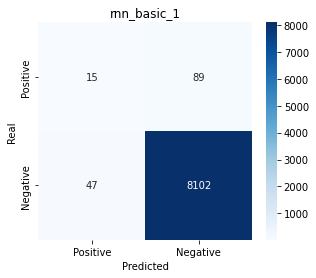

accuracy  : 98.35000000000001
precision : [98.91 24.19]
recall    : [99.42 14.42]
f1_score  : [99.17 18.07]

2th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 21, 34) (33011, 1)
check scale: 0.0 1.0

test: (8253, 21, 34) (8253, 1)
check scale: 0.0 1.0
up-sampled train dataset: (65188, 21, 34) (65188, 1)
MLP model has been restored from ./h5/rnn_basic_2_100_5_100_cv_2of10.h5


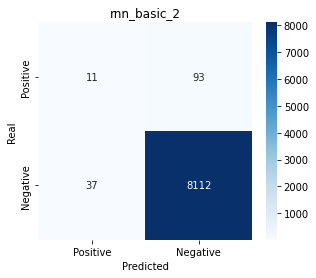

accuracy  : 98.42
precision : [98.87 22.92]
recall    : [99.55 10.58]
f1_score  : [99.21 14.47]

3th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 21, 34) (33011, 1)
check scale: 0.0 1.0

test: (8253, 21, 34) (8253, 1)
check scale: 0.0 1.0263605442176873
up-sampled train dataset: (65188, 21, 34) (65188, 1)
MLP model has been restored from ./h5/rnn_basic_2_100_5_100_cv_3of10.h5


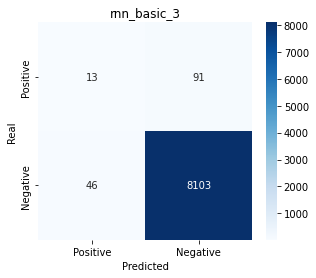

accuracy  : 98.34
precision : [98.89 22.03]
recall    : [99.44 12.5 ]
f1_score  : [99.16 15.95]

4th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 21, 34) (33011, 1)
check scale: 0.0 1.0

test: (8253, 21, 34) (8253, 1)
check scale: 0.0 1.0
up-sampled train dataset: (65188, 21, 34) (65188, 1)
MLP model has been restored from ./h5/rnn_basic_2_100_5_100_cv_4of10.h5


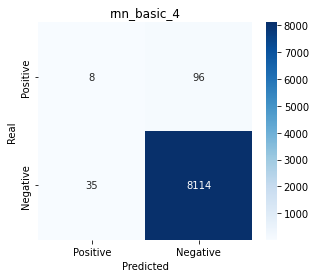

accuracy  : 98.41
precision : [98.83 18.6 ]
recall    : [99.57  7.69]
f1_score  : [99.2  10.88]

5th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 21, 34) (33011, 1)
check scale: 0.0 1.0

test: (8253, 21, 34) (8253, 1)
check scale: 0.0 1.0090634441087611
up-sampled train dataset: (65188, 21, 34) (65188, 1)
MLP model has been restored from ./h5/rnn_basic_2_100_5_100_cv_5of10.h5


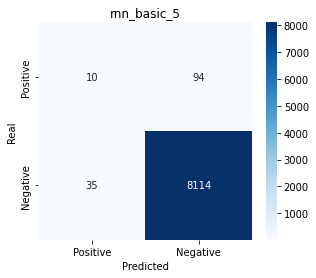

accuracy  : 98.44000000000001
precision : [98.85 22.22]
recall    : [99.57  9.62]
f1_score  : [99.21 13.42]

6th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 21, 34) (33011, 1)
check scale: 0.0 1.0

test: (8253, 21, 34) (8253, 1)
check scale: 0.0 1.0
up-sampled train dataset: (65188, 21, 34) (65188, 1)
MLP model has been restored from ./h5/rnn_basic_2_100_5_100_cv_6of10.h5


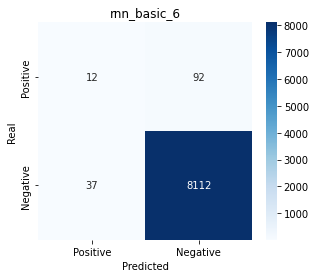

accuracy  : 98.44000000000001
precision : [98.88 24.49]
recall    : [99.55 11.54]
f1_score  : [99.21 15.69]

7th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 21, 34) (33011, 1)
check scale: 0.0 1.0

test: (8253, 21, 34) (8253, 1)
check scale: 0.0 1.0263605442176873
up-sampled train dataset: (65188, 21, 34) (65188, 1)
MLP model has been restored from ./h5/rnn_basic_2_100_5_100_cv_7of10.h5


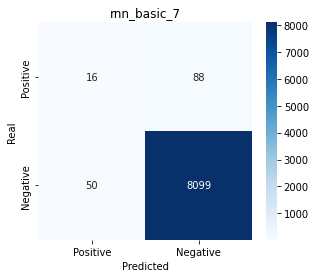

accuracy  : 98.33
precision : [98.93 24.24]
recall    : [99.39 15.38]
f1_score  : [99.16 18.82]

8th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 21, 34) (33011, 1)
check scale: 0.0 1.0

test: (8253, 21, 34) (8253, 1)
check scale: 0.0 1.0
up-sampled train dataset: (65188, 21, 34) (65188, 1)
MLP model has been restored from ./h5/rnn_basic_2_100_5_100_cv_8of10.h5


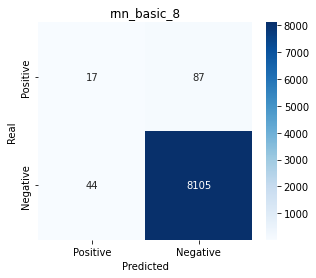

accuracy  : 98.41
precision : [98.94 27.87]
recall    : [99.46 16.35]
f1_score  : [99.2  20.61]

9th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 21, 34) (33011, 1)
check scale: 0.0 1.0

test: (8253, 21, 34) (8253, 1)
check scale: 0.0 1.0090634441087611
up-sampled train dataset: (65188, 21, 34) (65188, 1)
MLP model has been restored from ./h5/rnn_basic_2_100_5_100_cv_9of10.h5


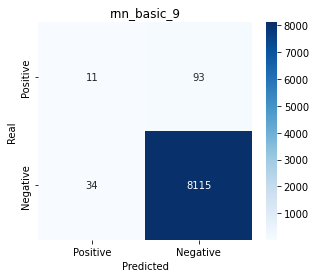

accuracy  : 98.46000000000001
precision : [98.87 24.44]
recall    : [99.58 10.58]
f1_score  : [99.22 14.77]

10th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 21, 34) (33011, 1)
check scale: 0.0 1.0

test: (8253, 21, 34) (8253, 1)
check scale: 0.0 1.001001001001001
up-sampled train dataset: (65188, 21, 34) (65188, 1)
MLP model has been restored from ./h5/rnn_basic_2_100_5_100_cv_10of10.h5


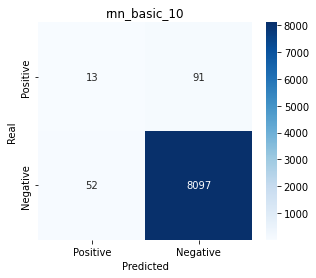

accuracy  : 98.27
precision : [98.89 20.  ]
recall    : [99.36 12.5 ]
f1_score  : [99.12 15.38]


In [ ]:
from src.graph_plot import *

for i in range(n_cv):
    print(f"\n{i+1}th iteration")
    random.seed(i+1)
    train_x, train_y, test_x, test_y, _, _ = stratified_split(rnn_input, rnn_output, 
                                                          test_size=test_size, random_state=i+1, 
                                                          scale_x=x_cts, scale_y=[])
    train_x, train_y = up_sampling(train_x, train_y)

    history_size = train_x.shape[1]
    x_dim = train_x.shape[2]
    y_dim = train_y.shape[1]
    save_path  = f'./h5/{model_name}_{rnn_layers}_{rnn_neurons}_{dnn_layers}_{dnn_neurons}_cv_{i+1}of{n_cv}.h5'

    model = RNN(history_size, x_dim, y_dim)
    model.build(rnn_layers, rnn_neurons, dnn_layers, dnn_neurons)
    model.load_model(save_path)
    
    prediction = model.model.predict(test_x, verbose=0)
    y_pred = prediction.round(0).astype(int)
    y_real = test_y
    
    plot_confusion(y_real, y_pred, title=model_name+f"_{i+1}", label=["Positive","Negative"])